## Connect to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [3]:
%cd 'B. Disease Grading' 

/content/drive/MyDrive/Colab Notebooks/B. Disease Grading


In [4]:
!ls

'1. Original Images'   CC-BY-4.0.txt   LICENSE.txt
'2. Groundtruths'      eff_b2_v2.pt    resnet50.pt


## Import packages

In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
import os
import glob
import cv2
import copy
from PIL import Image
import numpy as np
import pandas as pd
import random
from math import ceil
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

In [7]:
import os
import time
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Function
from torchsummary import summary
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import transforms
from torch.optim import lr_scheduler
from PIL import Image, ImageFile
from tqdm.notebook import tqdm as tqdm
import torch.cuda.amp as amp

device = torch.device("cuda:0")

## Set Seeding for numpy, torch, python

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 1999
seed_everything(seed)

## Analysis Data

In [9]:
train_image_dir = '1. Original Images/a. Training Set'
train_image_path = os.path.join(os.getcwd(),train_image_dir)

train_out_dir = '2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
train_out_path = os.path.join(os.getcwd(),train_out_dir)

test_image_dir = '1. Original Images/b. Testing Set'
test_image_path = os.path.join(os.getcwd(),test_image_dir)

test_out_dir = '2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'
test_out_path = os.path.join(os.getcwd(),test_out_dir)

In [10]:
train_df = pd.read_csv(train_out_dir)
test_df = pd.read_csv(test_out_dir)

In [11]:
print(f'There are {len(train_df)} images in train dataset')
print(f'There are {len(test_df)} images in test dataset')

There are 413 images in train dataset
There are 103 images in test dataset


In [12]:
columns = ['Image name', 'Retinopathy grade', 'Risk of macular edema ']
train_df = train_df.reindex(columns = columns)

In [13]:
train_df.head()

Image name  Retinopathy grade  Risk of macular edema 
0  IDRiD_001                  3                       2
1  IDRiD_002                  3                       2
2  IDRiD_003                  2                       2
3  IDRiD_004                  3                       2
4  IDRiD_005                  4                       0

In [14]:
train_df.describe()

Retinopathy grade  Risk of macular edema 
count         413.000000              413.000000
mean            1.719128                1.043584
std             1.387723                0.949215
min             0.000000                0.000000
25%             0.000000                0.000000
50%             2.000000                1.000000
75%             3.000000                2.000000
max             4.000000                2.000000

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Image name              413 non-null    object
 1   Retinopathy grade       413 non-null    int64 
 2   Risk of macular edema   413 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.8+ KB


In [16]:
test_df.describe()

Retinopathy grade  Risk of macular edema 
count         103.000000              103.000000
mean            1.728155                1.029126
std             1.415559                0.954415
min             0.000000                0.000000
25%             0.000000                0.000000
50%             2.000000                1.000000
75%             3.000000                2.000000
max             4.000000                2.000000

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Image name              103 non-null    object
 1   Retinopathy grade       103 non-null    int64 
 2   Risk of macular edema   103 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


### Check if all image has the same shape



In [ ]:
# img_size = []
# for img_path in glob.glob(train_image_path + '/*.jpg') + glob.glob(test_image_path + '/*.jpg'):
#   img = cv2.imread(img_path)
#   img_size.append(img.shape)

# img_size = set(img_size)
# print(f'Shape of all image in dataset is {img_size}')

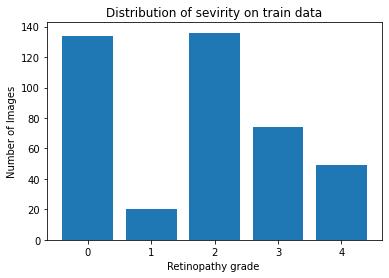

In [ ]:
count = train_df.groupby('Retinopathy grade').nunique()

grade = [0,1,2,3,4]
num_image = count['Image name']
plt.bar(grade,num_image)
plt.xlabel('Retinopathy grade ')
plt.ylabel('Number of Images')
plt.title('Distribution of sevirity on train data')
plt.show()

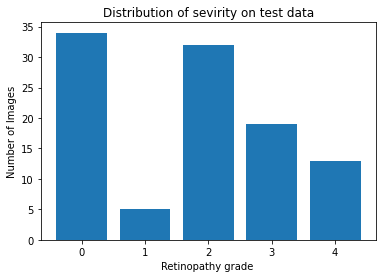

In [ ]:
count = test_df.groupby('Retinopathy grade').nunique()

grade = [0,1,2,3,4]
num_image = count['Image name']
plt.bar(grade,num_image)
plt.xlabel('Retinopathy grade ')
plt.ylabel('Number of Images')
plt.title('Distribution of sevirity on test data')
plt.show()

## Visualize Images

In [18]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=ceil(len(img_matrix_list) / ncols), ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

In [19]:
def plot_random_images(main_title, image_folder_path, df, num = 12, transform = None):
    img_dict = {}
    for idx, row, in df.iterrows():
      try:
          image_name, severity, risk = row[0], row[1], row[2]
          if image_name not in img_dict:
              img_dict[image_name] = [severity, risk]
      except Exception as e:
        print(e)

    # randomly choose 12 images to plot
    img_files_list = np.random.choice(list(img_dict.keys()), num)
    print("The images' names are {}".format(img_files_list))
    img_matrix_list = []
    img_title_list = []

    for img_file in img_files_list:
        image_file_path = os.path.join(image_folder_path, img_file + '.jpg')
        if transform:
          img = transform(image_file_path)
        else:
          img = cv2.imread(image_file_path)[:,:,::-1]  
        img_matrix_list.append(img)
        title = f'Name: {img_file}-Severity: {img_dict[img_file][0]}-Risk: {img_dict[img_file][1]}'
        img_title_list.append(title)
    
    return plot_multiple_img(img_matrix_list, title_list = img_title_list, ncols = 4, main_title=main_title)

The images' names are ['IDRiD_308' 'IDRiD_129' 'IDRiD_311' 'IDRiD_217' 'IDRiD_048' 'IDRiD_324'
 'IDRiD_088' 'IDRiD_320' 'IDRiD_035' 'IDRiD_393' 'IDRiD_396' 'IDRiD_275']


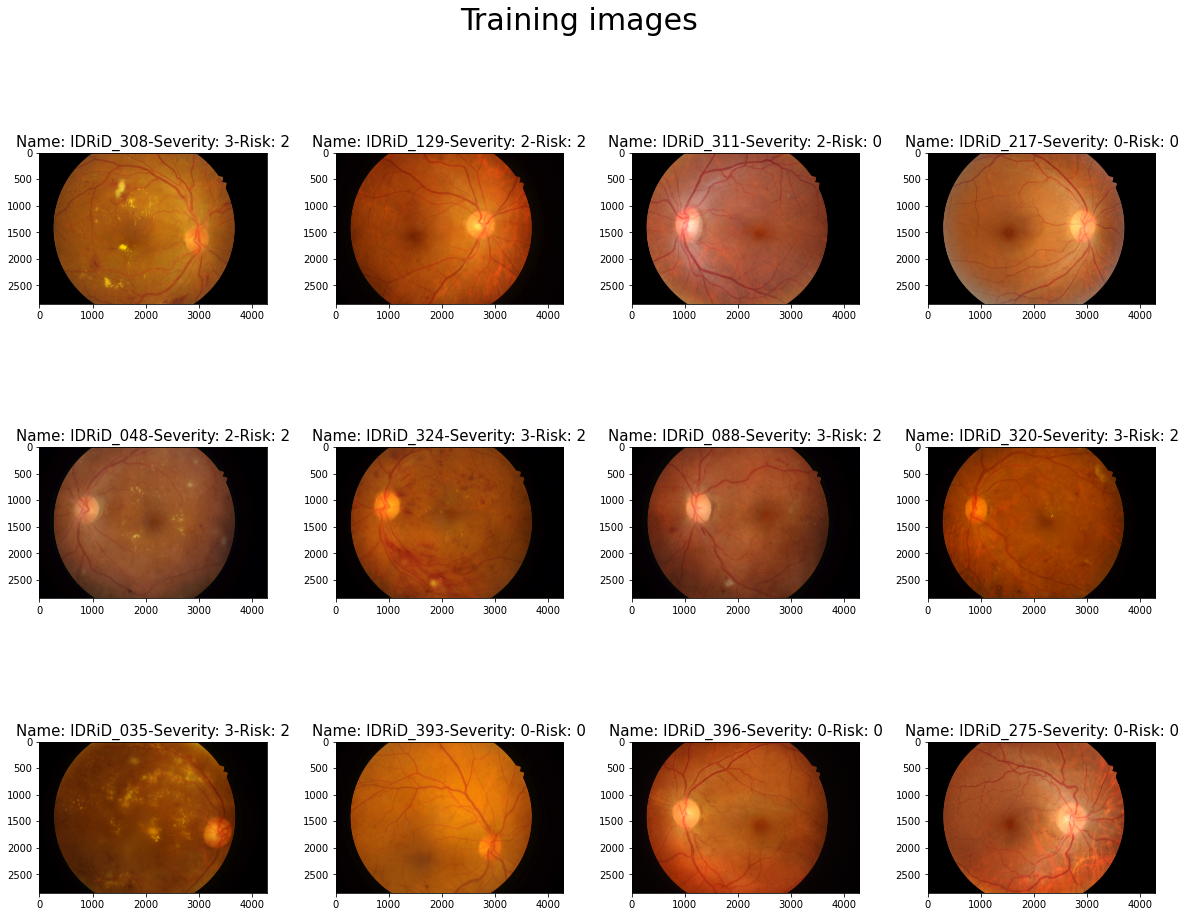

CPU times: user 12.4 s, sys: 73.5 ms, total: 12.4 s
Wall time: 20 s


In [ ]:
%%time
plot_random_images("Training images", train_image_path, train_df)

In [ ]:
def plot_image_per_class(image_folder_path, df, num_per_class, type):
  classes = tuple(np.unique(df[type].values))

  img_matrix_list = []
  img_title_list = []

  def read_img(img_name):
    img_path = os.path.join(image_folder_path, img_name + '.jpg')
    img = cv2.imread(img_path)[:,:,::-1]  

    return img
  
  for c in classes:
    images = tuple(df[df[type] == c]['Image name'].values)
    choose_imgs = list(np.random.choice(images, num_per_class))
    img_path_lsts = list(map(lambda x: read_img(x), choose_imgs))
    img_matrix_list += img_path_lsts

    for img in choose_imgs:
      title = f'Name: {img}-Level: {c}'
      img_title_list.append(title)

  return plot_multiple_img(img_matrix_list=img_matrix_list, title_list=img_title_list, ncols=num_per_class, main_title=type)

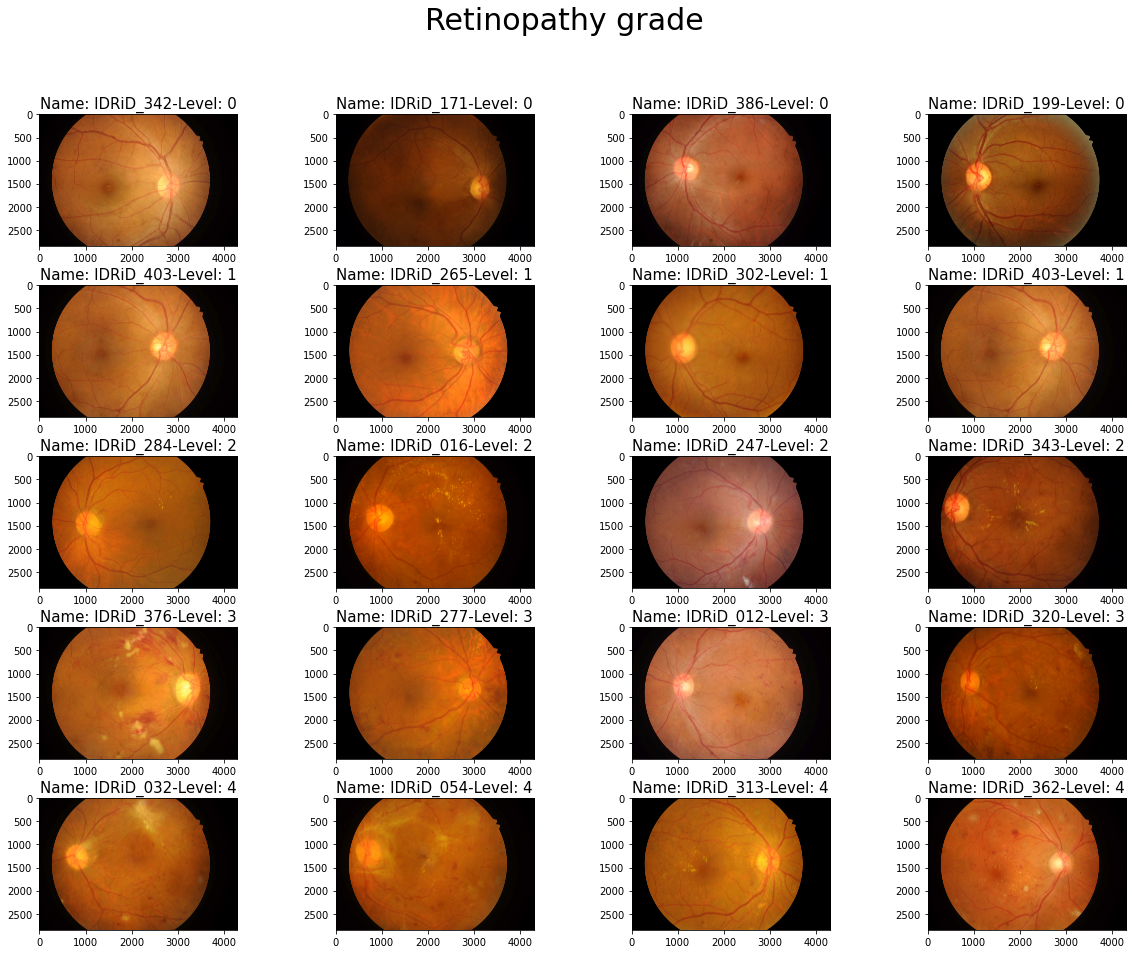

CPU times: user 18.9 s, sys: 172 ms, total: 19 s
Wall time: 31.6 s


In [ ]:
%%time
plot_image_per_class(train_image_path, train_df, 4, 'Retinopathy grade')

### Define image processing method

In [20]:
## Code references: https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [21]:
# Code references: https://www.kaggle.com/taindow/pre-processing-train-and-test-images

def circle_crop(img, sigmaX=30):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def load_ben_color(path, img_size = 512, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (img_size, img_size))
    image=cv2.addWeighted( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

The images' names are ['IDRiD_069' 'IDRiD_349' 'IDRiD_243' 'IDRiD_157' 'IDRiD_344' 'IDRiD_391'
 'IDRiD_271' 'IDRiD_085' 'IDRiD_046' 'IDRiD_012' 'IDRiD_384' 'IDRiD_244']


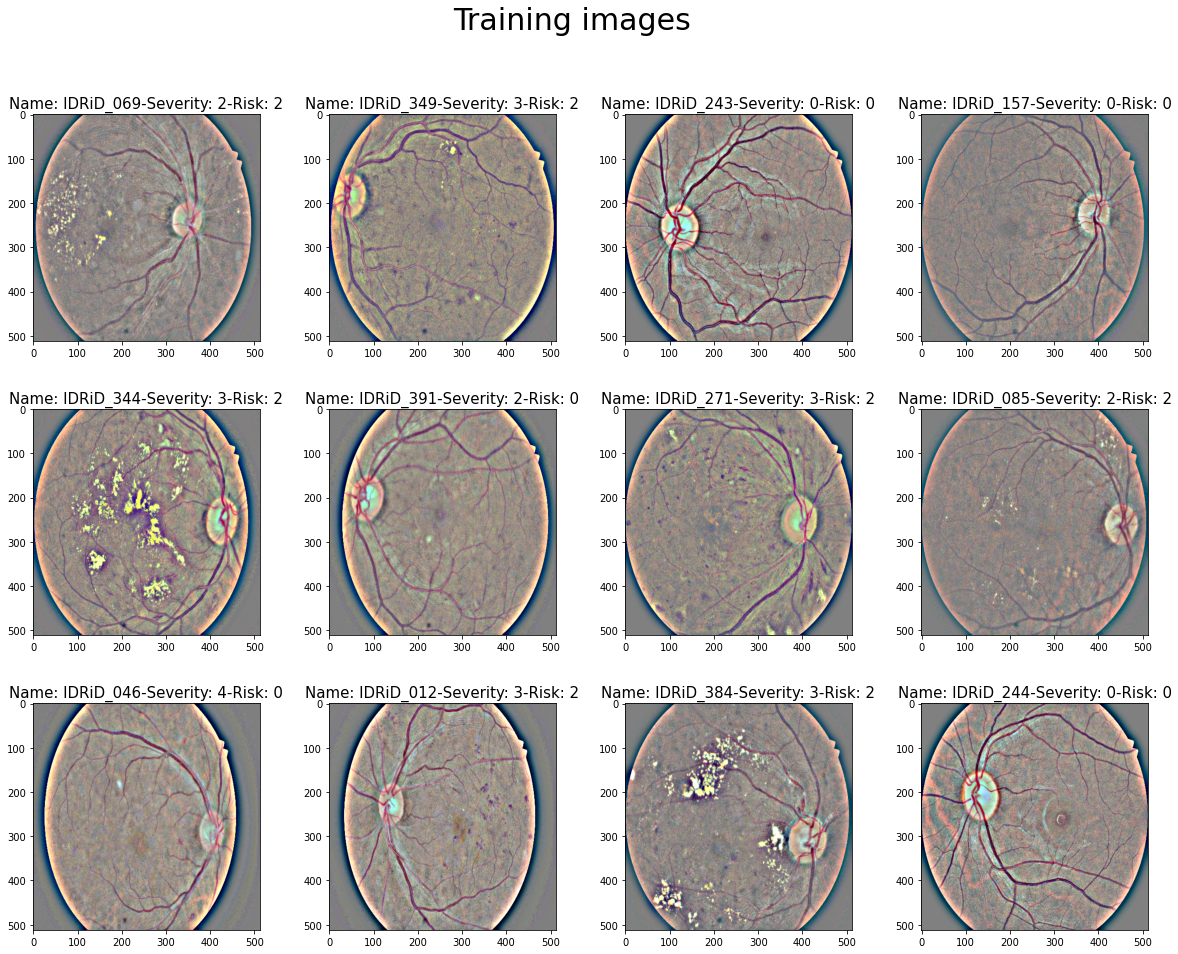

CPU times: user 6.85 s, sys: 40.5 ms, total: 6.89 s
Wall time: 13.2 s


In [ ]:
%%time
plot_random_images("Training images", train_image_path, train_df, transform=load_ben_color)

The images' names are ['IDRiD_387' 'IDRiD_242' 'IDRiD_169' 'IDRiD_300' 'IDRiD_044' 'IDRiD_274'
 'IDRiD_302' 'IDRiD_063' 'IDRiD_276' 'IDRiD_284' 'IDRiD_268' 'IDRiD_059']


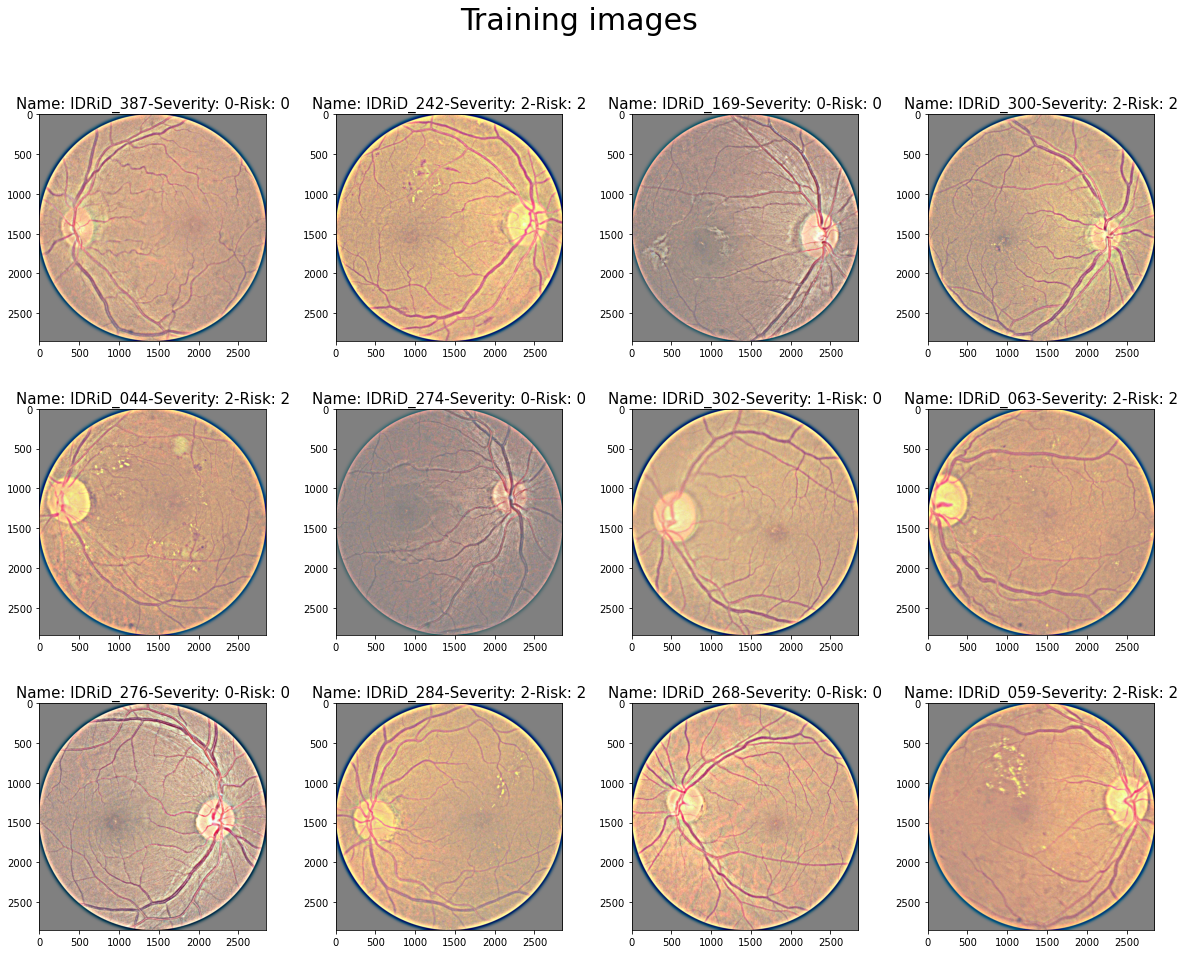

CPU times: user 1min 16s, sys: 117 ms, total: 1min 16s
Wall time: 52.8 s


In [ ]:
%%time
plot_random_images("Training images", train_image_path, train_df, transform=circle_crop)

### Compare image before and after processing

512 512


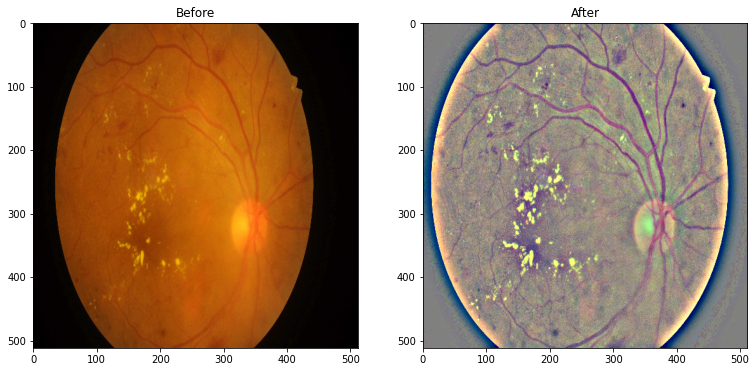

In [ ]:
dpi = 80 #inch

path= os.path.join(train_image_path, str(train_df['Image name'][0]) + '.jpg')

origin_image = cv2.imread(path)
origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)
origin_image = cv2.resize(origin_image, (512, 512))

image = load_ben_color(path,sigmaX=10)

height, width = 512, 512
print(height, width)

SCALE=0.5
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig, ax = plt.subplots(1, 2, figsize  = figsize)
ax[0].imshow(origin_image)
ax[0].set_title('Before')
ax[1].imshow(image, cmap='gray')
ax[1].set_title('After')

plt.show()

## Augmentations

<img src='https://albumentations.ai/docs/images/getting_started/augmenting_images/augmentation_pipeline_visualized.jpg'>

### Visualize some augmentation techniques

In [27]:
from torchvision import transforms

In [ ]:
def visualize_augmentations(image_path, idx=0, samples=10, cols=5):
    img = cv2.imread(image_path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = transforms.ToPILImage()(image)

    transform = transforms.Compose([
                                   transforms.RandomHorizontalFlip(p=0.6),
                                   transforms.RandomRotation((-120, 120)),
    ])

    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image = transform(image)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

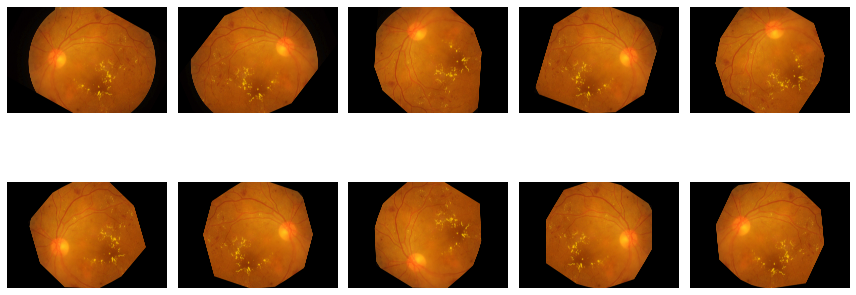

In [ ]:
visualize_augmentations(os.path.join(train_image_path, str(train_df['Image name'][0]) + '.jpg'))

## Modeling

### Define Dataset

In [22]:
class RetinopathyDatasetTrain(Dataset):
    def __init__(self, csv_file, img_path, transforms = None):
        self.data = pd.read_csv(csv_file)
        self.img_path = img_path
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data['Image name'][idx]
        image_path = os.path.join(self.img_path, img_name + '.jpg')

        image = load_ben_color(image_path, img_size=512)
        image = transforms.ToPILImage()(image)

        if self.transforms:
          image = self.transforms(image)
        
        label = torch.tensor(self.data.loc[idx, 'Retinopathy grade'])

        return image, label

### Define model

In [ ]:
model_1 = torchvision.models.resnet50(pretrained=True)

for param in model_1.parameters():
    param.requires_grad = True

num_features = model_1.fc.in_features
model_1.fc = nn.Linear(num_features, 5)

model_1 = model_1.to(device)

In [ ]:
summary(model_1, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

###Install timm package to use efficient net pretrained model

In [24]:
!pip install -q timm

     |████████████████████████████████| 348kB 31.3MB/s 


In [25]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)

In [ ]:
print(model_names)

['adv_inception_v3', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_mini', 'coat_lite_tiny', 'cspdarknet53', 'cspresnet50', 'cspresnext50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'densenetblur121d', 'dla34', 'dla46_c', 'dla46x_c', 'dla60', 'dla60_res2net', 'dla60_res2next', 'dla60x', 'dla60x_c', 'dla102', 'dla102x', 'dla102x2', 'dla169', 'dm_nfnet_f0', 'dm_nfnet_f1', 'dm_nfnet_f2', 'dm_nfnet_f3', 'dm_nfnet_f4', 'dm_nfnet_f5', 'dm_nfnet_f6', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'eca_nfnet_l0', 'eca_nfnet_l1', 'ecaresnet26t', 'ecaresnet50d', 'ecaresnet50d_pruned', 'ecaresnet50t', 'ecaresnet101d', 'ecaresnet101d_pruned', 'ecaresnet269d', 'ecaresnetlight', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b1_pruned', 'efficientnet_b2', 'efficientnet_b2_pruned', 'efficientnet_b3', 'efficientnet_b3_pruned', 'efficientn

### Define efficientnet pretrained model

In [54]:
model_2 = timm.create_model('tf_efficientnetv2_b3', pretrained=True)

for param in model_2.parameters():
    param.requires_grad = True

model_2.conv_stem.requires_grad_ = False
model_2.bn1.requires_grad_ = False
model_2.bn1.track_running_stats = False

in_features = model_2.classifier.in_features
model_2.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(in_features, 5)
) 

model_2 = model_2.to(device)

### Define transform for data augmentations

In [55]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-60, 60)),
    transforms.GaussianBlur(kernel_size=5),
    transforms.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])           
])

trainset     = RetinopathyDatasetTrain(train_out_path, train_image_path, transforms =train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
valset       = RetinopathyDatasetTrain(test_out_path, test_image_path, transforms =val_transform)
val_loader   = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [56]:
dataloaders = {'train' : train_loader, 'val' : val_loader}
dataset_sizes = {'train' : len(trainset) , 'val' : len(valset)}

### Define Logging class to log training and validation information

In [30]:
class Logging:
  def __init__(self):
        # history of loss values in each epoch
        self.loss_history={
            "train": [],
            "val": [],
        }

        # histroy of metric values in each epoch
        self.metrics_history={
            "train": [],
            "val": [],
        }
  
  def log(self, loss, acc, training):
        if training:
            train_val = "train"
        else:
            train_val = "val"

        self.loss_history[train_val].append(loss)
        self.metrics_history[train_val].append(acc)

### Define training method

In [31]:
def train_model(model, log, optimizer, scheduler, criterion, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    scaler = amp.GradScaler()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])), desc = 'Progress')
            counter = 0
            # Iterate over data.
            for inputs, labels in tk0:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with amp.autocast():
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      _, preds = torch.max(outputs, 1)
                      loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                   scaler.scale(loss).backward()
                   scaler.step(optimizer)
                   # Updates the scale for next iteration.
                   scaler.update()

                # statistics
                running_loss += loss.detach().cpu().item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

                counter += 1
                tk0.set_postfix(loss=(running_loss / (counter * dataloaders[phase].batch_size)), acc = (running_corrects / (counter * dataloaders[phase].batch_size)) )

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step(epoch_acc)
            
            log.log(epoch_loss, epoch_acc, phase == 'train')

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Traning

In [ ]:
## Train resnet50 model
log = Logging()
optimizer = optim.Adam(model_1.parameters(), lr = 0.001, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5)
criterion = nn.CrossEntropyLoss()
resnet50 = train_model(model_1, log, optimizer, scheduler, criterion)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



train Loss: 1.3154 Acc: 0.4431



val Loss: 40.2403 Acc: 0.2039

Epoch 1/14
----------



train Loss: 1.0620 Acc: 0.5714



val Loss: 7.9785 Acc: 0.3495

Epoch 2/14
----------



train Loss: 0.9793 Acc: 0.5932



val Loss: 4.2660 Acc: 0.2913

Epoch 3/14
----------



train Loss: 0.8912 Acc: 0.6320



val Loss: 2.0833 Acc: 0.3689

Epoch 4/14
----------



train Loss: 0.9019 Acc: 0.6223



val Loss: 4.3615 Acc: 0.3495

Epoch 5/14
----------



train Loss: 0.8420 Acc: 0.6465



val Loss: 1.3668 Acc: 0.4466

Epoch 6/14
----------



train Loss: 0.8469 Acc: 0.6513



val Loss: 1.1400 Acc: 0.5631

Epoch 7/14
----------



train Loss: 0.8104 Acc: 0.6368



val Loss: 1.0174 Acc: 0.6214

Epoch 8/14
----------



train Loss: 0.7408 Acc: 0.6973



val Loss: 1.0224 Acc: 0.6019

Epoch 9/14
----------



train Loss: 0.7647 Acc: 0.6707



val Loss: 1.1653 Acc: 0.5534

Epoch 10/14
----------



train Loss: 0.7526 Acc: 0.6877



val Loss: 1.1734 Acc: 0.6019

Epoch 11/14
----------



train Loss: 0.8293 Acc: 0.6513



val Loss: 1.3198 Acc: 0.5049

Epoch 12/14
----------



train Loss: 0.7266 Acc: 0.7191



val Loss: 1.8124 Acc: 0.5340

Epoch 13/14
----------



train Loss: 0.7272 Acc: 0.6804



val Loss: 1.1888 Acc: 0.6311

Epoch 14/14
----------



train Loss: 0.7116 Acc: 0.7119



val Loss: 1.3444 Acc: 0.5728

Training complete in 39m 44s
Best val Acc: 0.631068


In [ ]:
# Save best model to disk
torch.save(resnet50.state_dict(), os.path.join(os.getcwd(), 'resnet50.pt'))

In [ ]:
loss_hist, metrics_history = log.loss_history, log.metrics_history
train_hist = metrics_history["train"]
val_hist = metrics_history["val"]

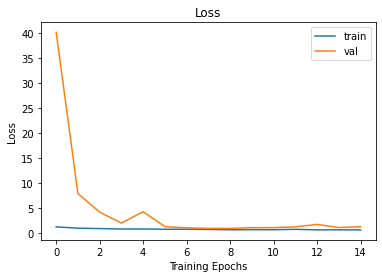

In [ ]:
# Train-Validation Progress
# plot loss progress

plt.title("Loss")
plt.plot(range(14+1),loss_hist["train"],label="train")
plt.plot(range(14+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

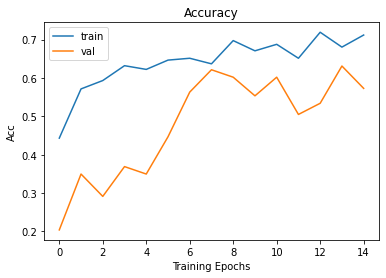

In [ ]:
# Train-Validation Progress

# plot loss progress
plt.title("Accuracy")
plt.plot(range(14+1),train_hist,label="train")
plt.plot(range(14+1),val_hist,label="val")
plt.ylabel("Acc")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [57]:
#Train efficientnet model
log = Logging()
params = filter(lambda p: p.requires_grad, model_2.parameters())
optimizer = optim.Adam(params, lr = 0.0001, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5)
criterion = nn.CrossEntropyLoss()
tf_efficientnetv2_b3 = train_model(model_2, log, optimizer, scheduler, criterion)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



train Loss: 6.0618 Acc: 0.1308



val Loss: 4.8049 Acc: 0.2524

Epoch 1/14
----------



train Loss: 3.4752 Acc: 0.5061



val Loss: 2.7981 Acc: 0.4757

Epoch 2/14
----------



train Loss: 1.9376 Acc: 0.5666



val Loss: 2.0977 Acc: 0.4563

Epoch 3/14
----------



train Loss: 1.2654 Acc: 0.6368



val Loss: 1.8791 Acc: 0.5243

Epoch 4/14
----------



train Loss: 0.9485 Acc: 0.6755



val Loss: 1.4704 Acc: 0.5631

Epoch 5/14
----------



train Loss: 0.7706 Acc: 0.7240



val Loss: 1.3387 Acc: 0.6214

Epoch 6/14
----------



train Loss: 0.6965 Acc: 0.7385



val Loss: 1.2231 Acc: 0.5922

Epoch 7/14
----------



train Loss: 0.5712 Acc: 0.7893



val Loss: 1.3264 Acc: 0.6408

Epoch 8/14
----------



train Loss: 0.5356 Acc: 0.8232



val Loss: 1.3309 Acc: 0.6214

Epoch 9/14
----------



train Loss: 0.4475 Acc: 0.8668



val Loss: 1.3409 Acc: 0.6214

Epoch 10/14
----------



train Loss: 0.3856 Acc: 0.8571



val Loss: 1.4128 Acc: 0.5534

Epoch 11/14
----------



train Loss: 0.3600 Acc: 0.8741



val Loss: 1.4819 Acc: 0.5922

Epoch 12/14
----------



train Loss: 0.3555 Acc: 0.8862



val Loss: 1.5302 Acc: 0.6214

Epoch 13/14
----------



train Loss: 0.2926 Acc: 0.9177



val Loss: 1.4412 Acc: 0.6311

Epoch 14/14
----------



train Loss: 0.2372 Acc: 0.9298



val Loss: 1.3759 Acc: 0.6311

Training complete in 45m 17s
Best val Acc: 0.640777


In [58]:
torch.save(tf_efficientnetv2_b3.state_dict(), os.path.join(os.getcwd(), 'tf_efficientnetv2_b3.pt'))

In [59]:
loss_hist, metrics_history = log.loss_history, log.metrics_history
train_hist = metrics_history["train"]
val_hist = metrics_history["val"]

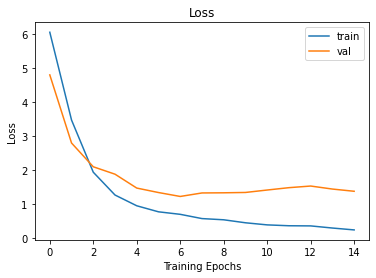

In [60]:
# Train-Validation Progress

# plot loss progress
plt.title("Loss")
plt.plot(range(15),loss_hist["train"],label="train")
plt.plot(range(15),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

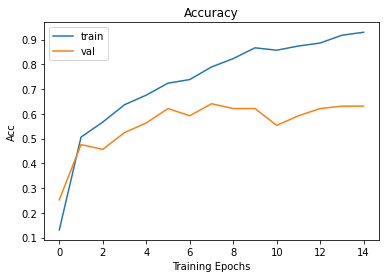

In [61]:
# Train-Validation Progress

# plot loss progress
plt.title("Accuracy")
plt.plot(range(15),train_hist,label="train")
plt.plot(range(15),val_hist,label="val")
plt.ylabel("Acc")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

## Grad-CAM Visualization 
Code reference: https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/gradcam.py

In [62]:
class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

In [63]:
class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x

In [64]:
def preprocess_image(img_path):
    img = load_ben_color(img_path)
    img = val_transform(img)
    img.unsqueeze_(0)
    input = img.requires_grad_(True)
    return input

In [72]:
def show_cam_on_image(img, mask):
    from google.colab.patches import cv2_imshow
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))
    cv2_imshow(np.uint8(255 * cam))

In [66]:
class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

[[0.00881021 0.00881021 0.00881021 ... 0.01795979 0.01795979 0.01795979]
 [0.00881021 0.00881021 0.00881021 ... 0.01795979 0.01795979 0.01795979]
 [0.00881021 0.00881021 0.00881021 ... 0.01795979 0.01795979 0.01795979]
 ...
 [0.0155481  0.0155481  0.0155481  ... 0.03567433 0.03567433 0.03567433]
 [0.0155481  0.0155481  0.0155481  ... 0.03567433 0.03567433 0.03567433]
 [0.0155481  0.0155481  0.0155481  ... 0.03567433 0.03567433 0.03567433]]


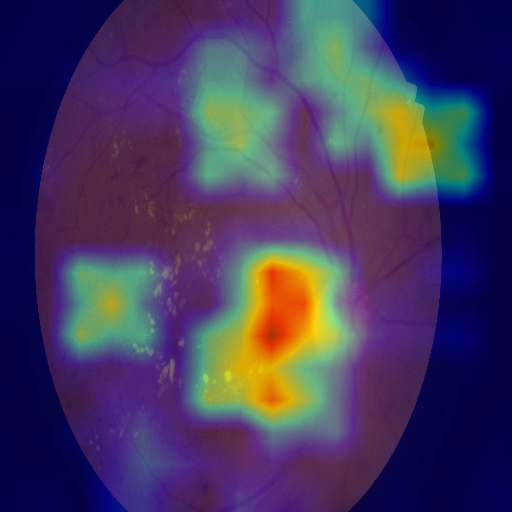

In [73]:
#Using resnet50 model to extract feature map to visualize heatmap because resnet50 has better result
#Result image is saved into disk with name cam.jpg
model = torchvision.models.resnet50(pretrained=False)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 5)
model.load_state_dict(torch.load(os.path.join(os.getcwd(), 'resnet50.pt')))
model = model.to(device)

grad_cam = GradCam(model= model, feature_module=model.layer4, target_layer_names=["2"], use_cuda=True)

path= os.path.join(train_image_path, str(train_df['Image name'][0]) + '.jpg')
img = cv2.imread(path, 1)
img = np.float32(cv2.resize(img, (512, 512))) / 255

input = preprocess_image(path)

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.
target_index = None
mask = grad_cam(input, target_index)

print(mask)

show_cam_on_image(img, mask)